<a href="https://colab.research.google.com/github/amridhav/Multimodal-Analysis-of-BMD/blob/main/finalcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import numpy as np
from scipy.ndimage import gaussian_filter, zoom, rotate, map_coordinates

import warnings
warnings.filterwarnings("ignore")

%pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
import os

Flip, rotate, crop

Text(0.5, 1.0, 'Cropped Image')

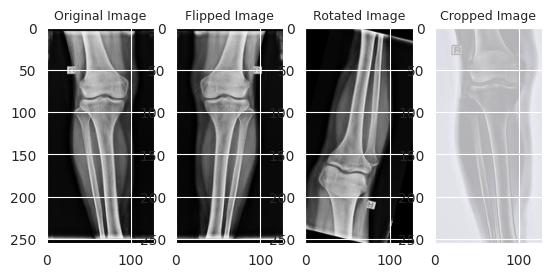

In [ ]:
import cv2,os
img_path='/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_163.jpg'
img=cv2.imread(img_path)

def random_flip2d(input_):
    flip = random.randint(0, 2) # 0, 1, 2

    if   flip == 0:
        return input_[:, ::-1]
    elif flip == 1:
        return input_[::-1, :]
    elif flip == 2:
        return input_[::-1, ::-1]
    elif flip == 3:
        return input_

def random_rotate2d(input_):
    angle = random.randint(10, 350)
    rotate_input  = rotate(input_, angle,   reshape=False)
    return rotate_input

def random_crop2d(input_):
    zoom_rates = [1.2, 1.3, 1.4]
    zoom_rate  = random.choice(zoom_rates)

    zoom_input  = zoom(input_,  zoom_rate)
    zoom_shape, img_shape = zoom_input.shape, input_.shape
    dx = random.randint(0, zoom_shape[0] - img_shape[0])
    dy = random.randint(0, zoom_shape[1] - img_shape[1])

    zoom_input  = zoom_input[dx:dx + img_shape[0], dy:dy + img_shape[1]]
    return zoom_input

imgflp=random_flip2d(img)
imgrdrot=random_rotate2d(img)
imgrdcp=random_crop2d(img)

import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original Image',size =9)
plt.subplot(1,4,2)
plt.imshow(imgflp)
plt.title('Flipped Image',size =9)
plt.subplot(1,4,3)
plt.imshow(imgrdrot)
plt.title('Rotated Image',size =9)
plt.subplot(1,4,4)
plt.imshow(imgrdcp)
plt.title('Cropped Image',size =9)

CLACHE algo

PSNR: 27.9290127777145 dB


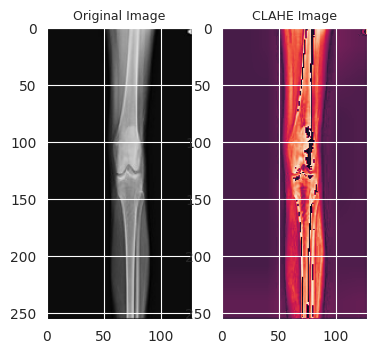

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reading the image from the present directory
org_image = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_103.jpg')
# Resizing the image for compatibility
image = cv2.resize(org_image, (500, 600))

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=5)
final_img = clahe.apply(image_bw) + 30

# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

# Showing the two images
plt.subplot(131)
plt.imshow(org_image)
plt.title('Original Image', size =9)
plt.subplot(132)
plt.imshow(final_img)
plt.title('CLAHE Image', size =9)

# Load the original image and the enhanced image
org_image = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_143.jpg', cv2.IMREAD_GRAYSCALE)
enhanced_image = final_img

# Ensure both images have the same size
height, width = org_image.shape[:2]
enhanced_image = cv2.resize(enhanced_image, (width, height))

# Calculate the Mean Squared Error (MSE)
mse = np.mean((org_image - enhanced_image) ** 2)

# Calculate PSNR using the formula PSNR = 20 * log10(MAX) - 10 * log10(MSE)
max_pixel_value = 255  # For 8-bit images
psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

# Display the PSNR value
print(f'PSNR: {psnr} dB')

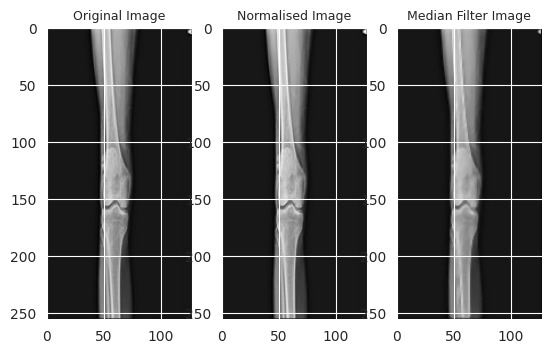

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import cv2,os

def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = numpy.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final


def main():
    #img=cv2.imread("/content/drive/MyDrive/osteo_DEXA/ost_DS/osteoporosis/1 (33).PNG").convert("L")
    #imgs = Image.open("/content/drive/MyDrive/osteo_DEXA/ost_DS/osteoporosis/1 (33).PNG")
    org_img = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_173.jpg', cv2.IMREAD_GRAYSCALE)
    arr = numpy.array(org_img)
    removed_noise = median_filter(arr, 3)
    img_med = Image.fromarray(removed_noise)
    # Load the bone scan image
    org_img = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_173.jpg')

    # Normalize the image to the [0, 255] range
    normalized_image = cv2.normalize(org_img, None, 0, 255, cv2.NORM_MINMAX)

    # Display the original and normalized images

    plt.subplot(131)
    plt.imshow(org_img)
    plt.title('Original Image', size =9)
    plt.subplot(132)
    plt.imshow(normalized_image)
    plt.title('Normalised Image', size =9)
    plt.subplot(133)
    plt.imshow(img_med)
    plt.title('Median Filter Image', size =9)
main()


In [ ]:
org_image = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_103.jpg')
# Resizing the image for compatibility
image = cv2.resize(org_image, (500, 600))

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=5)
final_img = clahe.apply(image_bw) + 30

# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

# Showing the two images
plt.subplot(131)
plt.imshow(org_image)
plt.title('Original Image', size =9)
plt.subplot(132)
plt.imshow(final_img)
plt.title('CLAHE Image', size =9)

# Load the original image and the enhanced image
org_image = cv2.imread('/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis/Osteoporosis_143.jpg', cv2.IMREAD_GRAYSCALE)
enhanced_image = final_img

# Ensure both images have the same size
height, width = org_image.shape[:2]
enhanced_image = cv2.resize(enhanced_image, (width, height))

# Calculate the Mean Squared Error (MSE)
mse = np.mean((org_image - enhanced_image) ** 2)

# Calculate PSNR using the formula PSNR = 20 * log10(MAX) - 10 * log10(MSE)
max_pixel_value = 255  # For 8-bit images
psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

# Display the PSNR value
print(f'PSNR: {psnr} dB')

In [ ]:
import cv2
import numpy as np
import os

# Folder containing the images
image_folder = '/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/osteoporosis'

# Load the original/reference image (e.g., ground truth)
#reference_image = cv2.imread('reference_image.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize an empty list to store PSNR values
psnr_values = []
psnr_val = []

# Loop through all image files in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):  # Filter image files by extension
        # Load the current image
        org_image = cv2.imread(os.path.join(image_folder, filename))

        # Resizing the image for compatibility
        image = cv2.resize(org_image, (500, 600))

        # The initial processing of the image
        # image = cv2.medianBlur(image, 3)
        image_bw = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

        # The declaration of CLAHE
        # clipLimit -> Threshold for contrast limiting
        clahe = cv2.createCLAHE(clipLimit=5)
        final_img = clahe.apply(image_bw) + 30

        # Ordinary thresholding the same image
        _, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

        # Load the original image and the enhanced image
        org_image = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        enhanced_image = final_img

        # Ensure both images have the same size
        height, width = org_image.shape[:2]
        enhanced_image = cv2.resize(enhanced_image, (width, height))

        # Calculate the Mean Squared Error (MSE)
        mse = np.mean((org_image - enhanced_image) ** 2)

        # Calculate PSNR using the formula PSNR = 20 * log10(MAX) - 10 * log10(MSE)
        max_pixel_value = 255  # For 8-bit images
        psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)
        # Append the PSNR value to the list
        psnr_values.append((filename, psnr))
        psnr_val.append(psnr)

avg_value = np.mean(psnr_val)
print(avg_value)

28.21897786124364


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2,os

def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = numpy.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final


def main():
    # Folder containing the images
    image_folder = '/content/drive/MyDrive/osteo_XR_knee(186)/osteo_DS/normal'

    # Load the original/reference image (e.g., ground truth)

    # Initialize an empty list to store PSNR values
    psnr_values = []
    psnr_val = []

    # Loop through all image files in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):  # Filter image files by extension
            # Load the current image
            img = cv2.imread(os.path.join(image_folder, filename),cv2.IMREAD_GRAYSCALE)

            arr = numpy.array(img)
            removed_noise = median_filter(arr, 3)
            img1 = Image.fromarray(removed_noise)

            filtered_image = img1

            # Calculate the Mean Squared Error (MSE)

            mse = np.mean((img - filtered_image) ** 2)
            # Calculate PSNR using the formula PSNR = 20 * log10(MAX) - 10 * log10(MSE)
            max_pixel_value = 255  # For 8-bit images
            psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

            # Display the PSNR value'''
            psnr_values.append((filename, psnr))
            psnr_val.append(psnr)

    avg_value = np.mean(psnr_val)
    print(avg_value)
main()